**NOTE:**
* Size/volume of tumor linked to survival?
* Sphericity linked to aggressiveness? 

In [4]:
!pip install pynrrd

In [3]:
import sys
sys.path.append('./')

import os
import nrrd
import nrrd

from _backend import ioutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Graylevel Statistics

In [4]:
paths_to_ct = ioutil.relative_paths('./../../../data_source/images/ct_anomaly_filtered_nrrd', target_format='nrrd')
paths_to_pet = ioutil.relative_paths('./../../../data_source/images/pet_anomaly_filtered_nrrd', target_format='nrrd')
paths_to_mask = ioutil.relative_paths('./../../../data_source/images/masks_resegm_nrrd', target_format='nrrd')
ct, pet = {}, {}
for num, path_to_ct in enumerate(paths_to_ct):
    
    ct_image, _ = nrrd.read(path_to_ct)
    ct[path_to_ct] = ct_image
    
    pet_image, _ = nrrd.read(paths_to_pet[num])
    pet[paths_to_pet[num]] = pet_image

In [6]:
def calc_image_statistics(image):
    
    return {
        'gl_mean': np.mean(image),
        'gl_median': np.median(image),
        'gl_min': np.min(image),
        'gl_max': np.max(image)
    }

In [9]:
# Statistics on original (not masked) images.
ct_stats, pet_stats = {}, {}
for num, (pet_image, ct_image) in enumerate(zip(pet.values(), ct.values())):
    
    pet_stats[num] = calc_image_statistics(pet_image)
    ct_stats[num] = calc_image_statistics(ct_image)

df_ct_stats = pd.DataFrame(ct_stats)
df_pet_stats = pd.DataFrame(pet_stats)

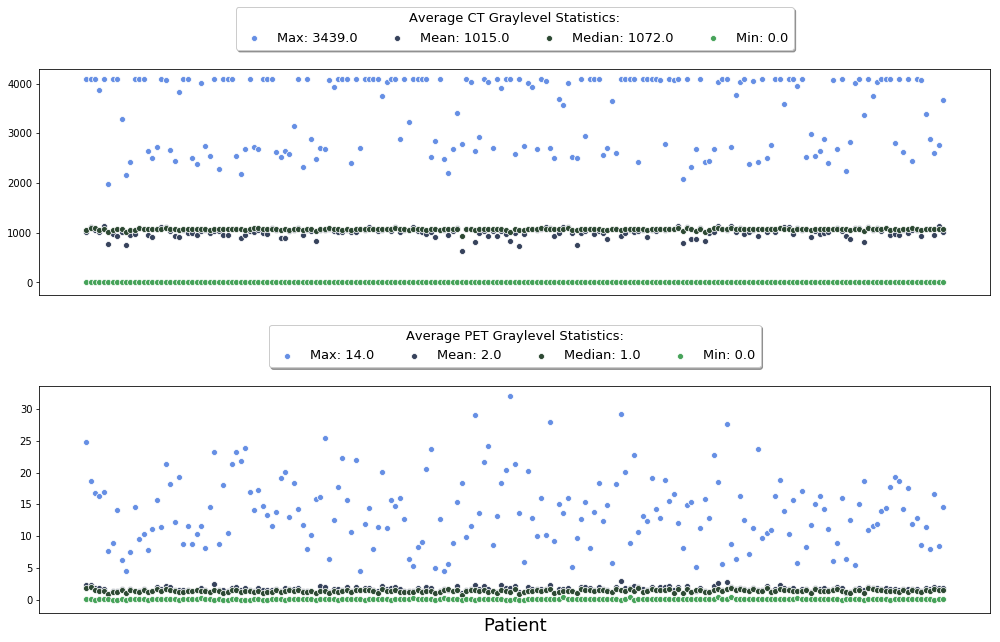

In [13]:
from matplotlib import rcParams, cycler

colours = sns.diverging_palette(255, 133, l=60, n=4, center="dark")
rcParams['axes.prop_cycle'] = cycler(color=colours)

fig, (ct_axis, pet_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
for pet_row_label, ct_row_label in zip(df_pet_stats.T, df_ct_stats.T):
    sns.scatterplot(
        x=np.squeeze(df_ct_stats.columns.values), 
        y=np.squeeze(df_ct_stats.loc[ct_row_label, :].values),
        ax=ct_axis,
    )
    sns.scatterplot(
        x=np.squeeze(df_pet_stats.columns.values), 
        y=np.squeeze(df_pet_stats.loc[pet_row_label, :].values),
        ax=pet_axis,
    )
pet_axis.legend(
    [
        'Max: {0}'.format(np.round(df_pet_stats.loc['gl_max'].mean()), 2), 
        'Mean: {0}'.format(np.round(df_pet_stats.loc['gl_mean'].mean()), 2), 
        'Median: {0}'.format(np.round(df_pet_stats.loc['gl_median'].mean()), 2), 
        'Min: {0}'.format(np.round(df_pet_stats.loc['gl_min'].mean()), 2)
    ],
    title='Average PET Graylevel Statistics:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.3),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
ct_axis.legend(
    [
        'Max: {0}'.format(np.round(df_ct_stats.loc['gl_max'].mean()), 2), 
        'Mean: {0}'.format(np.round(df_ct_stats.loc['gl_mean'].mean()), 2), 
        'Median: {0}'.format(np.round(df_ct_stats.loc['gl_median'].mean()), 2), 
        'Min: {0}'.format(np.round(df_ct_stats.loc['gl_min'].mean()), 2)
    ],
    title='Average CT Graylevel Statistics:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.3),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
plt.xlabel('Patient', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.savefig(
    './../../../figures/gl_characteristics.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

In [46]:
y_dfs = pd.read_csv('./../../../data_source/to_analysis/target_dfs.csv', index_col=0)
y_lrr = pd.read_csv('./../../../data_source/to_analysis/target_lrr.csv', index_col=0)
"""
NOTE: 

The original DFS data is oriented as DFS(T) = 0, DFS(F) = 1. Reversing for 
the more intuitive interpretaion of target as 

    if occuring: DFS = 1
    if not occuring: DFS = 0

"""
orig_dfs = np.squeeze(y_dfs.values)
y_dfs_reversed = np.copy(orig_dfs)
y_dfs_reversed[orig_dfs == 0] = -2
y_dfs_reversed = y_dfs_reversed  - 1
y_dfs_reversed[orig_dfs == 0] = 1

assert sum(orig_dfs) + sum(y_dfs_reversed) == np.size(y_dfs.values)

outcome_mapping = {
    'no_dfs_lrr': 2,
    'only_dfs': 1,
    'only_lrr': 0
}

target_dummies = np.zeros(np.size(y_dfs), dtype=int)
for num, (dfs, lrr) in enumerate(zip(y_dfs_reversed, y_lrr.values)):
    # Only DFS.
    if dfs == 1 and lrr == 0:
        target_dummies[num] = outcome_mapping['only_dfs']
    # Only LRR.
    elif dfs == 0 and lrr == 1:
        target_dummies[num] = outcome_mapping['only_lrr']
    # Patient experiencing neither of DFS or LRR.
    else: 
        target_dummies[num] = outcome_mapping['no_dfs_lrr']
        
target_dummies

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0,
       1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2, 2,
       0, 1, 2, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1])

# Oucomes

In [103]:
y = pd.read_csv('./../../../data_source/to_analysis/target_dfs.csv', index_col=0)
outcome_ratios = [
    float(y.sum() / np.size(y)), float(1 - y.sum() / np.size(y)),
]
outcome_ratios

[0.32323232323232326, 0.6767676767676767]

"\n\nfig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True, sharex=True);\n\nsns.countplot(\n    x=y_dfs_reversed, \n    ax=axes[0], \n    saturation=0.85, \n    palette=['blue', 'darkgreen'], \n    alpha=0.7\n)\naxes[0].set_ylabel('Count', fontsize=20)\naxes[0].set_xticklabels(['True', 'False',])\n\nsns.countplot(\n    x='lrr', data=y_lrr, \n    ax=axes[1], \n    saturation=0.85, \n    palette=['blue', 'darkgreen'],\n    alpha=0.7,\n)\naxes[1].set_ylabel('')\naxes[1].set_xticklabels(['False', 'True'])\n\ncount = 0\nfor num, axis in enumerate(axes):\n    axis.set_xlabel(main_titles[num], fontsize=18)\n    axis.tick_params(labelsize=16)\n    axis.set_ylim([0, 170])\n    for patch in axis.patches:\n        current_width = patch.get_width()\n        diff = current_width - 0.4\n        # Change the bar width,\n        patch.set_width(0.4)\n        # Recenter the bar,\n        patch.set_x(patch.get_x() + diff * 0.5)\n        \n        axis.annotate(\n            '{:.1f}%'.format(ou

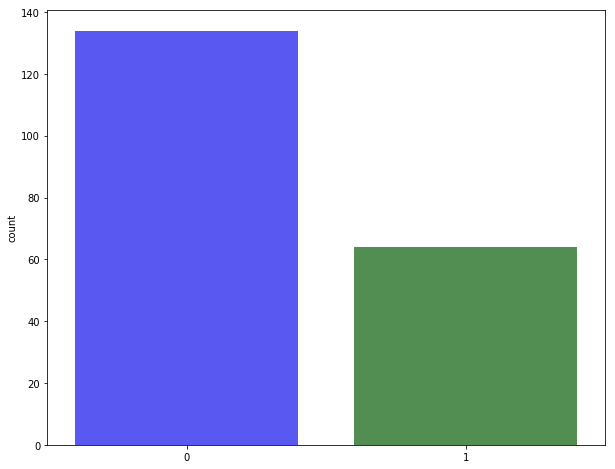

In [106]:
plt.figure(figsize=(10, 8))
sns.countplot(
    x=np.squeeze(y.values),
    saturation=0.85, 
    palette=['blue', 'darkgreen'], 
    alpha=0.7
)



"""

fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True, sharex=True);

sns.countplot(
    x=y_dfs_reversed, 
    ax=axes[0], 
    saturation=0.85, 
    palette=['blue', 'darkgreen'], 
    alpha=0.7
)
axes[0].set_ylabel('Count', fontsize=20)
axes[0].set_xticklabels(['True', 'False',])

sns.countplot(
    x='lrr', data=y_lrr, 
    ax=axes[1], 
    saturation=0.85, 
    palette=['blue', 'darkgreen'],
    alpha=0.7,
)
axes[1].set_ylabel('')
axes[1].set_xticklabels(['False', 'True'])

count = 0
for num, axis in enumerate(axes):
    axis.set_xlabel(main_titles[num], fontsize=18)
    axis.tick_params(labelsize=16)
    axis.set_ylim([0, 170])
    for patch in axis.patches:
        current_width = patch.get_width()
        diff = current_width - 0.4
        # Change the bar width,
        patch.set_width(0.4)
        # Recenter the bar,
        patch.set_x(patch.get_x() + diff * 0.5)
        
        axis.annotate(
            '{:.1f}%'.format(outcome_ratios[count] * 100),
            (patch.get_x() + patch.get_width() / 3.5, patch.get_height() + 3), 
            color='k', 
            fontsize=16
        )
        count = count + 1

plt.tight_layout()
plt.savefig(
    './../../../figures/outcome_distr',
    bbox_inches='tight',
    transparent=True,
    dpi=400, 
)
"""